In [1]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import numpy as np
import torchvision
import matplotlib.pyplot as plt

# loading dataset

In [2]:
def get_data(batchsize):
  train_transforms = transforms.Compose([transforms.ToTensor()])
  train_data = MNIST(root = './train', train = True, download=True, transform=train_transforms)
  test_data = MNIST(root = './test', train = True, download=True, transform=train_transforms)

  train_loader = DataLoader(train_data, batch_size=batchsize, shuffle = True, drop_last=True)
  test_loader = DataLoader(test_data, batch_size=batchsize, shuffle = False,drop_last=True)

  return train_loader, test_loader

In [3]:
def plot_sample(data_loader):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    grid = torchvision.utils.make_grid(images)

    npimg = grid.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title('Sample Images')
    plt.axis('off')
    plt.show()


In [4]:
batch_size = 32
train_loader, test_loader = get_data(batch_size)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11808933.24it/s]


Extracting ./train/MNIST/raw/train-images-idx3-ubyte.gz to ./train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 354584.66it/s]


Extracting ./train/MNIST/raw/train-labels-idx1-ubyte.gz to ./train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3279271.32it/s]


Extracting ./train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4197076.18it/s]


Extracting ./train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11820570.15it/s]


Extracting ./test/MNIST/raw/train-images-idx3-ubyte.gz to ./test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 345832.23it/s]


Extracting ./test/MNIST/raw/train-labels-idx1-ubyte.gz to ./test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3231817.07it/s]


Extracting ./test/MNIST/raw/t10k-images-idx3-ubyte.gz to ./test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3194789.33it/s]

Extracting ./test/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./test/MNIST/raw



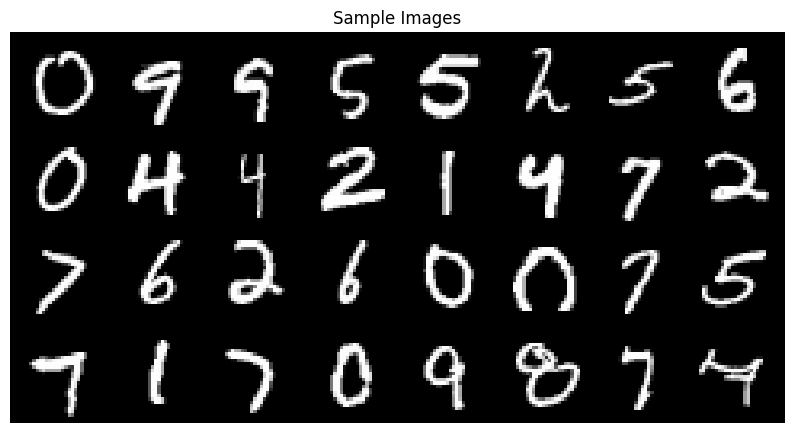

In [5]:
plot_sample(train_loader)

In [6]:
images, labels = next(iter(train_loader))

In [7]:
images.shape

torch.Size([32, 1, 28, 28])

# Define network architecture

In [8]:
class Generator(nn.Module):
    def __init__(self, batch_size, input_dim):
        super().__init__()
        self.batch_size = batch_size  # Batch size for input data
        self.input_dim = input_dim  # Dimension of the input data
        self.fc1 = nn.Linear(input_dim, 128)  # Fully connected layer 1
        self.LRelu = nn.LeakyReLU()  # Leaky ReLU activation function
        self.fc2 = nn.Linear(128, 1 * 28 * 28)  # Fully connected layer 2
        self.tanH = nn.Tanh()  # Hyperbolic Tangent activation function

    # Function for forward propagation
    def forward(self, x):
        layer1 = self.LRelu(self.fc1(x))  # Apply Leaky ReLU to the first fully connected layer
        layer2 = self.tanH(self.fc2(layer1))  # Apply Tanh to the second fully connected layer
        out = layer2.view(self.batch_size, 1, 28, 28)  # Reshape the output to match image dimensions
        return out

In [9]:
class Discriminator(nn.Module):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.fc1 = nn.Linear(1 * 28 * 28, 128)
        self.LReLu = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, 1)
        self.SigmoidL = nn.Sigmoid()

    def forward(self, x):
        flat = x.view(self.batch_size, -1)
        layer1 = self.LReLu(self.fc1(flat))
        out = self.SigmoidL(self.fc2(layer1))
        return out.view(-1, 1).squeeze(1)

# Training loop

In [10]:
def train_model(epochs, disc, gen, optimD, optimG, dataloaders, loss_fn, input_size, batch_size):

  device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")

  reall = 1
  fakel = 0
  for epoch in range(epochs):

    loss_g = 0
    loss_d = 0

    for phase in ['train', 'test']:
      for inputs,_ in dataloaders[phase]:
        inputs = inputs.to(device)
        real_label = torch.full((batch_size,), reall, dtype=inputs.dtype, device=device)
        fake_label = torch.full((batch_size,), fakel, dtype=inputs.dtype, device=device)

        optimD.zero_grad()

        output = disc(inputs)

        D_real_loss = loss_fn(output, real_label)
        D_real_loss.backward()

        noise = torch.randn(batch_size, input_size, device=device)
        fake = gen(noise)
        output = disc(fake.detach())

        D_fake_loss = loss_fn(output, fake_label)
        D_fake_loss.backward()
        Disc_loss = D_real_loss + D_fake_loss
        loss_d += Disc_loss
        optimD.step()
        optimG.zero_grad()

        output = disc(fake)
        Gen_loss = loss_fn(output, real_label)
        loss_g = loss_g + Gen_loss
        Gen_loss.backward()
        optimG.step()

    print("Discriminator Loss : {}".format(loss_d))
    print("Generator Loss : {}".format(loss_g))


# Training objectives

In [12]:
torch.manual_seed(42)

batch_size = 128
epochs = 5
input_size = 100

train_loader, test_loader = get_data(batchsize=batch_size)
dl = {}
dl['train'] = train_loader
dl['test'] = test_loader

disc = Discriminator(batch_size=batch_size)
gen = Generator(batch_size=batch_size, input_dim=input_size)

optimD = torch.optim.Adam(disc.parameters(), lr= 0.001, weight_decay=1e-5)
optimG = torch.optim.Adam(gen.parameters(), lr= 0.001, weight_decay=1e-5)

loss_fn = torch.nn.BCELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
disc.to(device)
gen.to(device)
train_model(epochs, disc, gen, optimD, optimG, dl, loss_fn, input_size, batch_size)

cuda
Discriminator Loss : 1117.319580078125
Generator Loss : 1166.7618408203125
Discriminator Loss : 1341.4990234375
Generator Loss : 766.8427124023438
Discriminator Loss : 1271.5572509765625
Generator Loss : 782.4405517578125
Discriminator Loss : 1209.295166015625
Generator Loss : 1013.5673217773438
Discriminator Loss : 1100.950927734375
Generator Loss : 1212.2276611328125


In [13]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

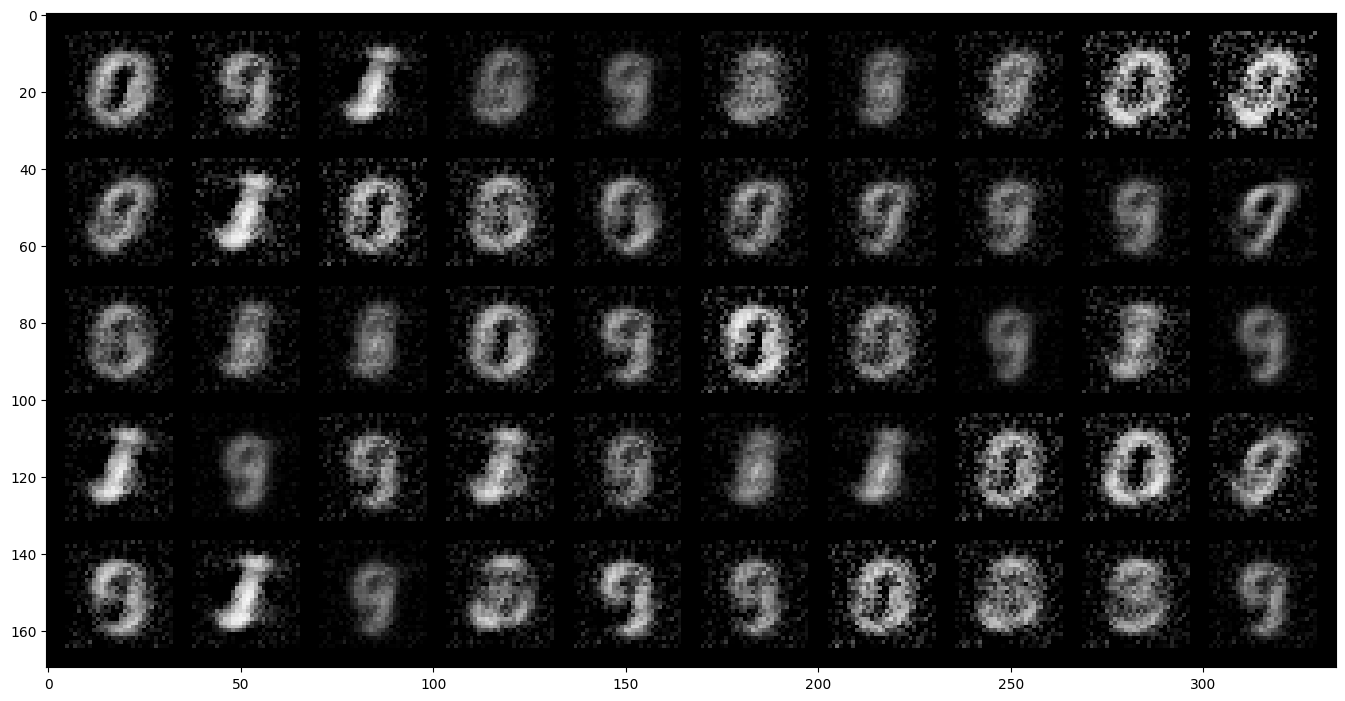

In [15]:
random_noise = torch.randn(128, input_size, device=device)

fake = gen(random_noise)
fake = fake.cpu()
fig, ax = plt.subplots(figsize=(20, 8.5))
show_image(torchvision.utils.make_grid(fake[0:50], 10, 5))

plt.show()